In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import pathlib

## Loading data

In [2]:
directory_path = '../../04 - Dev/videos'
currentDirectory = pathlib.Path(directory_path)
currentPattern = "*.annotated.csv"
file_list = [str(currentFile) for currentFile in currentDirectory.glob(currentPattern)]
file_list

['../../04 - Dev/videos/WIN_20210409_10_26_11_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210417_14_53_12_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210330_13_10_29_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210414_06_24_52_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/Video_1.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/Test_pour_AFPA.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210408_14_02_19_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210404_21_41_12_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210415_15_41_24_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210331_21_22_52_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210407_14_54_56_Pro_edit2.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210407_09_04_05_Pro.mp4.wav.emobase.annotated.csv',
 '../../04 - Dev/videos/WIN_20210329_10

In [3]:
df_total = pd.DataFrame()
for filename in file_list:
    df = pd.read_csv(filename, delimiter=';')
    df_total = pd.concat([df_total, df], axis=0)


In [4]:
print('Number of videos', df_total['video_name'].nunique())
print('Number of annotations', df_total[['video_name','diapo']].drop_duplicates().shape[0])

Number of videos 30
Number of annotations 240


In [5]:
df_total.to_pickle(directory_path + '/audio_emobase_data.p')

In [6]:
df_total = pd.read_pickle(directory_path + '/audio_emobase_data.p')

In [7]:
df_total.shape

(2573701, 60)

## Data exploration

In [8]:
df_stats_stress_global = df_total[['video_name','stress_global']].drop_duplicates()['stress_global'].value_counts().sort_index()
df_stats_stress_global


0    12
1    10
2     8
Name: stress_global, dtype: int64

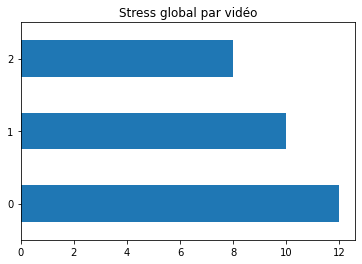

In [9]:
df_stats_stress_global.plot(kind='barh', title='Stress global par vidéo');


In [10]:
df_stats_stress = df_total[['video_name','diapo','stress']].drop_duplicates()['stress'].value_counts().sort_index()
df_stats_stress

0     91
1    112
2     33
3      4
Name: stress, dtype: int64

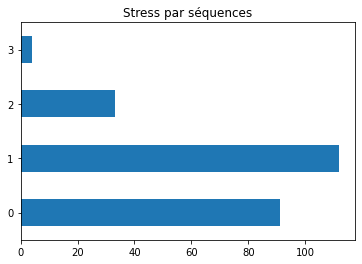

In [11]:
df_stats_stress.plot(kind='barh', title='Stress par séquences');

In [12]:
df_stats_stress_diapo = df_total[['video_name','diapo','stress']].drop_duplicates()[['diapo','stress']].groupby(['diapo','stress']).agg({'stress':'count'}).sort_index().unstack(fill_value=0)
df_stats_stress_diapo

stress          
stress      0   1  2  3
diapo                  
1          17  11  2  0
8          16  10  4  0
9          11  15  4  0
10         12  15  3  0
11         13  13  3  1
12          2  21  7  0
17         17  12  1  0
18          3  15  9  3

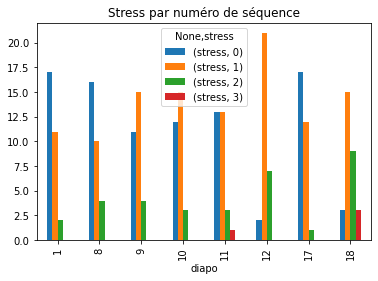

In [13]:
df_stats_stress_diapo.plot(kind='bar', title='Stress par numéro de séquence');

## Data pre-processing 1 - Sans utilisation de la temporalité

In [14]:
def percentil25(x): 
    return np.percentile(x, q=25)

def percentil75(x): 
    return np.percentile(x, q=75)

In [15]:
df_total

,frameIndex,frameTime,pcm_intensity_sma,pcm_loudness_sma,mfcc_sma[1],mfcc_sma[2],mfcc_sma[3],mfcc_sma[4],mfcc_sma[5],mfcc_sma[6],...,pcm_zcr_sma_de,voiceProb_sma_de,F0_sma_de,F0env_sma_de,video_name,stress_global,type_candidat,sexe,stress,diapo
0,0,0.00,0.000000e+00,0.000000,-1.839101,2.378769,-2.217382,1.524796,-0.692341,0.101261,...,-0.000242,0.016226,0.0,0.0,WIN_20210409_10_26_11_Pro,0,Stagiaire,F,1,1
1,1,0.01,0.000000e+00,0.000000,-1.839101,2.378769,-2.217382,1.524796,-0.692341,0.101261,...,-0.000393,0.007565,0.0,0.0,WIN_20210409_10_26_11_Pro,0,Stagiaire,F,1,1
2,2,0.02,0.000000e+00,0.000000,-5.952965,6.019684,-3.599674,1.358609,-0.693719,0.796165,...,-0.000272,0.011002,0.0,0.0,WIN_20210409_10_26_11_Pro,0,Stagiaire,F,1,1
3,3,0.03,0.000000e+00,0.000000,-4.113864,3.640915,-1.382292,-0.166187,-0.001379,0.694905,...,0.000000,0.009354,0.0,0.0,WIN_20210409_10_26_11_Pro,0,Stagiaire,F,1,1
4,4,0.04,0.000000e+00,0.000000,-5.911817,5.975944,-3.576790,1.367325,-0.725028,0.827764,...,0.000272,0.007488,0.0,0.0,WIN_20210409_10_26_11_Pro,0,Stagiaire,F,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78139,78139,781.39,8.054489e-12,0.029190,-19.760860,6.082466,-2.668031,5.229023,3.715201,-1.398331,...,-0.002025,0.012437,0.0,0.0,WIN_20210416_08_06_54_Pro,1,Stagiaire,F,2,18
78140,78140,781.40,4.319410e-12,0.023441,-21.733470,5.059051,-2.391827,4.356356,5.255848,-0.879569,...,-0.003778,0.021489,0.0,0.0,WIN_20210416_08_06_54_Pro,1,Stagiaire,F,2,18
78141,78141,781.41,3.975198e-12,0.022989,-21.913380,3.731894,-4.589119,0.219700,1.376662,-5.050643,...,-0.005409,0.040231,0.0,0.0,WIN_20210416_08_06_54_Pro,1,Stagiaire,F,2,18
78142,78142,781.42,3.662190e-12,0.022472,-22.256340,2.845562,-4.491580,2.111024,3.834707,-3.251046,...,-0.007011,0.052342,0.0,0.0,WIN_20210416_08_06_54_Pro,1,Stagiaire,F,2,18


In [16]:
from scipy.stats import kurtosis, skew
X = df_total.iloc[:,2:].groupby(['video_name','diapo']).agg({'mean','min','max', 'median', 'std', percentil25, percentil75, kurtosis, skew}).iloc[:,:-18]

In [17]:
X.columns

MultiIndex([('pcm_intensity_sma',         'std'),
            ('pcm_intensity_sma',         'max'),
            ('pcm_intensity_sma', 'percentil25'),
            ('pcm_intensity_sma',        'skew'),
            ('pcm_intensity_sma',      'median'),
            ('pcm_intensity_sma',    'kurtosis'),
            ('pcm_intensity_sma',         'min'),
            ('pcm_intensity_sma', 'percentil75'),
            ('pcm_intensity_sma',        'mean'),
            ( 'pcm_loudness_sma',         'std'),
            ...
            (        'F0_sma_de',        'mean'),
            (     'F0env_sma_de',         'std'),
            (     'F0env_sma_de',         'max'),
            (     'F0env_sma_de', 'percentil25'),
            (     'F0env_sma_de',        'skew'),
            (     'F0env_sma_de',      'median'),
            (     'F0env_sma_de',    'kurtosis'),
            (     'F0env_sma_de',         'min'),
            (     'F0env_sma_de', 'percentil75'),
            (     'F0env_sma_de', 

In [18]:
#X = X.drop( ['type_candidat','sexe'],axis=1)

In [19]:
X_temp = df_total[['video_name','diapo','type_candidat','sexe']].groupby(['video_name','diapo']).agg({'type_candidat':'first','sexe':'first'})
X_temp.loc[X_temp['type_candidat'] == 'Stagiaire','Stagiaire'] = 1
X_temp.loc[X_temp['type_candidat'] != 'Stagiaire','Stagiaire'] = 0
X_temp.loc[X_temp['sexe'] == 'F','Femme'] = 1
X_temp.loc[X_temp['sexe'] != 'F','Femme'] = 0
X_temp = X_temp.drop(['type_candidat','sexe'], axis=1)

In [20]:
X_temp

Stagiaire  Femme
video_name                diapo                  
Test_pour_AFPA            1            1.0    0.0
                          8            1.0    0.0
                          9            1.0    0.0
                          10           1.0    0.0
                          11           1.0    0.0
...                                    ...    ...
WIN_20210417_14_53_12_Pro 10           1.0    1.0
                          11           1.0    1.0
                          12           1.0    1.0
                          17           1.0    1.0
                          18           1.0    1.0

[240 rows x 2 columns]

In [21]:
X = pd.concat([X,X_temp],axis=1)

In [22]:
X

(pcm_intensity_sma, std)  \
video_name                diapo                             
Test_pour_AFPA            1                  2.748470e-07   
                          8                  1.159030e-06   
                          9                  1.142409e-06   
                          10                 1.367874e-06   
                          11                 1.446588e-06   
...                                                   ...   
WIN_20210417_14_53_12_Pro 10                 4.197754e-07   
                          11                 3.674674e-07   
                          12                 3.760241e-10   
                          17                 7.997970e-07   
                          18                 2.102153e-10   

                                 (pcm_intensity_sma, max)  \
video_name                diapo                             
Test_pour_AFPA            1                  1.795643e-05   
                          8                  2.552147e-05   
                          9                  4.923681e-05   
                          10                 5.260212e-05   
                          11                 6.543399e-05   
...                                                   ...   
WIN_20210417_14_53_12_Pro 10                 6.300619e-06   
                          11                 5.826240e-06   
                          12                 9.125553e-09   
                          17                 8.491340e-06   
                          18                 1.093041e-08   

                                 (pcm_intensity_sma, percentil25)  \
video_name                diapo                                     
Test_pour_AFPA            1                          3.821638e-11   
                          8                          7.489974e-11   
                          9                          6.744114e-11   
                          10                         5.894842e-11   
                          11                         7.155228e-11   
...                                                           ...   
WIN_20210417_14_53_12_Pro 10                         0.000000e+00   
                          11                         0.000000e+00   
                          12                         1.669329e-13   
                          17                         4.173518e-14   
                          18                         0.000000e+00   

                                 (pcm_intensity_sma, skew)  \
video_name                diapo                              
Test_pour_AFPA            1                      52.105435   
                          8                       8.773747   
                          9                      21.745491   
                          10                     23.775476   
                          11                     23.492521   
...                                                    ...   
WIN_20210417_14_53_12_Pro 10                      6.260282   
                          11                      4.954644   
                          12                     10.185306   
                          17                      4.658821   
                          18                     28.084717   

                                 (pcm_intensity_sma, median)  \
video_name                diapo                                
Test_pour_AFPA            1                     6.973596e-11   
                          8                     1.126761e-08   
                          9                     2.440317e-09   
                          10                    7.152661e-10   
                          11                    5.700818e-09   
...                                                      ...   
WIN_20210417_14_53_12_Pro 10                    2.086603e-13   
                          11                    6.047051e-11   
                          12                    2.128377e-12   
                          17        

In [23]:
y = df_total.iloc[:,2:].groupby(['video_name','diapo']).agg({'stress':'mean'}).iloc[:,-1]

In [24]:
y

video_name                 diapo
Test_pour_AFPA             1        1
                           8        1
                           9        0
                           10       0
                           11       0
                                   ..
WIN_20210417_14_53_12_Pro  10       0
                           11       0
                           12       1
                           17       1
                           18       2
Name: stress, Length: 240, dtype: int64

In [25]:
X.to_pickle(directory_path + '/audio_emobase_data_X.p')
y.to_pickle(directory_path + '/audio_emobase_data_y.p')

In [43]:
from scipy.stats import kurtosis, skew
X_audio = df_total.loc[df_total['diapo'].isin([8, 9, 10, 11, 17]),:].iloc[:,2:].groupby(['video_name','diapo']).agg({'mean','min','max', 'median', 'std', percentil25, percentil75, kurtosis, skew}).iloc[:,:-18]
y_audio = df_total.loc[df_total['diapo'].isin([8, 9, 10, 11, 17]),:].iloc[:,2:].groupby(['video_name','diapo']).agg({'stress':'mean'}).iloc[:,-1]


In [46]:
X_audio.to_pickle(directory_path + '/audio_emobase_data_X_audio.p')
y_audio.to_pickle(directory_path + '/audio_emobase_data_y_audio.p')

## Modèles

In [47]:
X = pd.read_pickle(directory_path + '/audio_emobase_data_X.p')
y = pd.read_pickle(directory_path + '/audio_emobase_data_y.p')

X_audio = pd.read_pickle(directory_path + '/audio_emobase_data_X_audio.p')
y_audio = pd.read_pickle(directory_path + '/audio_emobase_data_y_audio.p')

In [48]:
X.shape

(240, 470)

In [28]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42 )

In [29]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(Xtrain,ytrain)

ytrain_predict = lr.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = lr.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error without rounding the prediction', mean_squared_error(ypredict, ytest, squared=False))
print('TEST : mean_squared_error with rounding the prediction', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 2.7050754623992847e-15
TEST : mean_squared_error without rounding the prediction 0.8884152054509568
TEST : mean_squared_error with rounding the prediction 0.9052317076000179


In [32]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=7, random_state=42)
dt.fit(Xtrain, ytrain)

ytrain_predict = dt.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = dt.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))
print('TEST : mean_squared_error with rounding the prediction', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 0.0
TEST : mean_squared_error 0.7728015412913086
TEST : mean_squared_error with rounding the prediction 0.7728015412913086


In [33]:
#print(dt.feature_importances_)
print(np.argsort(dt.feature_importances_)[:-20:-1])
print(X.columns[np.argsort(dt.feature_importances_)[:-20:-1]])

[148 144 173  98 384 387 442 441 111 393 114 419 462 232 436  77 163  75
 110]
Index([        ('lspFreq_sma[2]', 'std'),         ('lspFreq_sma[2]', 'min'),
               ('lspFreq_sma[5]', 'max'),    ('mfcc_sma[9]', 'percentil25'),
         ('lspFreq_sma_de[2]', 'median'),      ('lspFreq_sma_de[3]', 'min'),
            ('voiceProb_sma_de', 'skew'),       ('voiceProb_sma_de', 'min'),
                ('mfcc_sma[11]', 'mean'),   ('lspFreq_sma_de[3]', 'median'),
              ('mfcc_sma[11]', 'median'), ('lspFreq_sma_de[6]', 'kurtosis'),
                ('F0env_sma_de', 'mean'),      ('F0env_sma', 'percentil75'),
               ('pcm_zcr_sma_de', 'std'),       ('mfcc_sma[7]', 'kurtosis'),
              ('lspFreq_sma[4]', 'skew'),           ('mfcc_sma[7]', 'mean'),
                 ('mfcc_sma[11]', 'max')],
      dtype='object')


In [34]:
dt.feature_importances_[118]

0.0

In [35]:
np.argsort([0, 2, 1, 4])

array([0, 2, 1, 3])

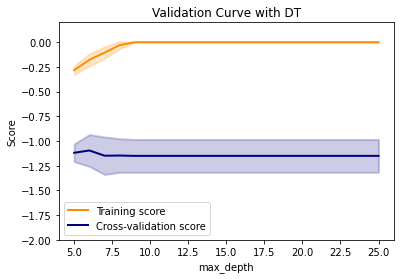

In [36]:
from sklearn.model_selection import validation_curve
param_range = [5, 6, 7, 8, 9,10, 11, 12, 13, 14, 15, 20, 25]
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42), X, y, param_name="max_depth", param_range=param_range,
    scoring="neg_root_mean_squared_error", n_jobs=8)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
plt.ylim(-2, 0.2)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(Xtrain, ytrain)
ytrain_predict = dt.predict(Xtrain)
ypredict = dt.predict(Xtest)
#ypredict[ypredict<0] = 0.0
#ypredict[ypredict>3] = 3.0
print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 0.0
TEST : mean_squared_error 0.8249579113843054


In [57]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
rf.fit(Xtrain, ytrain)

ytrain_predict = rf.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = rf.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

print('TRAIN : mean_squared_error without rounding the prediction', mean_squared_error(ytrain_predict, ytrain, squared=False))
print('TEST : mean_squared_error without rounding the prediction', mean_squared_error(ypredict, ytest, squared=False))
print('TEST : mean_squared_error with rounding the prediction', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

TRAIN : mean_squared_error without rounding the prediction 0.2738953657903251
TEST : mean_squared_error without rounding the prediction 0.5619064530508162
TEST : mean_squared_error with rounding the prediction 0.6346477588219923


In [58]:
print(X.columns[np.argsort(rf.feature_importances_)[:-20:-1]])

Index([     ('lspFreq_sma[4]', 'kurtosis'),
                    ('mfcc_sma[2]', 'std'),
                ('lspFreq_sma[6]', 'skew'),
       ('voiceProb_sma_de', 'percentil75'),
            ('lspFreq_sma[1]', 'kurtosis'),
         ('lspFreq_sma_de[6]', 'kurtosis'),
                   ('mfcc_sma[7]', 'mean'),
            ('lspFreq_sma[2]', 'kurtosis'),
                 ('lspFreq_sma[3]', 'min'),
              ('lspFreq_sma_de[4]', 'std'),
              ('voiceProb_sma_de', 'skew'),
             ('lspFreq_sma_de[7]', 'skew'),
                  ('mfcc_sma[12]', 'skew'),
                ('mfcc_sma_de[9]', 'skew'),
                 ('mfcc_sma[7]', 'median'),
                  ('voiceProb_sma', 'std'),
               ('voiceProb_sma_de', 'min'),
                ('mfcc_sma_de[7]', 'mean'),
              ('lspFreq_sma_de[3]', 'std')],
      dtype='object')


<AxesSubplot:xlabel='stress_annoté', ylabel='prediction'>

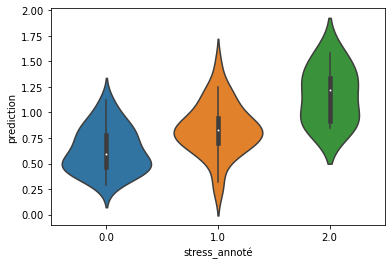

In [63]:
import seaborn as sns
df_compare = pd.DataFrame(np.stack([ypredict, ytest],axis=1),columns=['prediction','stress_annoté'])
df_compare
sns.violinplot(x="stress_annoté", y="prediction", data=df_compare)

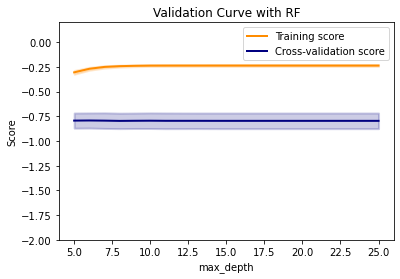

In [40]:
from sklearn.model_selection import validation_curve
param_range = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=100, random_state=42), X, y, param_name="max_depth", param_range=param_range,
    scoring="neg_root_mean_squared_error", n_jobs=8)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
plt.ylim(-2, 0.2)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [44]:
from xgboost import XGBClassifier
rf = XGBClassifier(n_estimators=100, max_depth=20, use_label_encoder=False,  objective='multi:softmax', num_class=4,)
rf.fit(Xtrain, ytrain, eval_metric='rmse')
ypredict = rf.predict(Xtest)
print('mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))

mean_squared_error 0.6123724356957945


In [45]:
from xgboost import XGBRegressor
rf = XGBRegressor(n_estimators=100, max_depth=20)
rf.fit(Xtrain, ytrain, eval_metric='rmse')
ypredict = rf.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0
print('mean_squared_error', mean_squared_error(ypredict, ytest, squared=False))

mean_squared_error 0.6086168300338333


In [ ]:
print('mean_squared_error', mean_squared_error(np.round(ypredict,0), ytest, squared=False))

In [ ]:
ytest.values

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(ytest.values, label='test')
plt.plot(ypredict, label='test predict')

In [ ]:
np.mean(ytest == ypredict)

In [ ]:
plt.hist(ytest.values - ypredict, bins = 7, label='test predict')

In [ ]:
from sklearn.metrics import plot_confusion_matrix
class_names = [0,1,2,3]
disp = plot_confusion_matrix(dt, Xtest, ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None #'true','pred', 'all'                                 )


## Classifiers

In [106]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

In [107]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
print(confusion_matrix(ytest_list, ypredict_list))
print(accuracy_score(ytest_list,ypredict_list))
print(f1_score(ytest_list, ypredict_list,labels=[0,1,2,3],average='weighted'))


[[59 31  1  0]
 [26 83  3  0]
 [ 2 24  7  0]
 [ 2  2  0  0]]
0.6208333333333333
0.5997222222222223


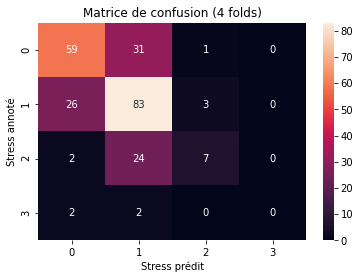

In [109]:
import seaborn as sns 
sns.heatmap(confusion_matrix(ytest_list,ypredict_list),annot=True)
plt.title('Matrice de confusion ('+str(4)+' folds)')
plt.ylabel('Stress annoté')
plt.xlabel('Stress prédit');

In [101]:
## Données audio seulement

In [110]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X_audio, y_audio)

for train_index, test_index in skf.split(X_audio, y_audio):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


In [88]:
y_audio.value_counts()

0    69
1    65
2    15
3     1
Name: stress, dtype: int64

In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
print(confusion_matrix(ytest_list,ypredict_list))
print(accuracy_score(ytest_list,ypredict_list))
print(f1_score(ytest_list,ypredict_list,labels=[0,1,2,3],average='weighted'))

[[12 34  1  0]
 [ 9 71  2  0]
 [ 0 18  0  0]
 [ 0  2  1  0]]
0.5533333333333333
0.48559628682390826


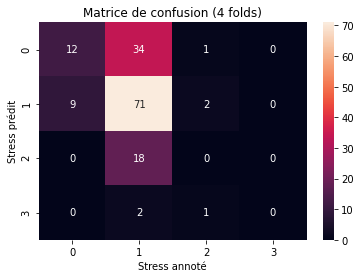

In [113]:
import seaborn as sns 
sns.heatmap(confusion_matrix(ytest_list,ypredict_list),annot=True)
plt.title('Matrice de confusion ('+str(4)+' folds)')
plt.ylabel('Stress prédit')
plt.xlabel('Stress annoté');

In [114]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
rf.fit(Xtrain, ytrain)

ytrain_predict = rf.predict(Xtrain)
ytrain_predict[ytrain_predict<0] = 0.0
ytrain_predict[ytrain_predict>3] = 3.0

ypredict = rf.predict(Xtest)
ypredict[ypredict<0] = 0.0
ypredict[ypredict>3] = 3.0

In [115]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

In [116]:
from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(ytest_list,ypredict_list, squared=False))
print(r2_score(ytest_list,ypredict_list))

0.6608076325110644
0.19125390720742852


In [117]:
ypredict_list, ytest_list = [], []

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
skf.get_n_splits(X_audio, y_audio)

for train_index, test_index in skf.split(X_audio, y_audio):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestRegressor(max_depth=7, n_estimators=100, random_state=42)
    rf.fit(Xtrain, ytrain)
    ypredict = rf.predict(Xtest)

    ypredict_list = np.concatenate([ypredict_list,ypredict])
    ytest_list = np.concatenate([ytest_list,ytest])

from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(ytest_list,ypredict_list, squared=False))
print(r2_score(ytest_list,ypredict_list))

/home/neo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
0.661406472659957
0.10690348001806138
